In [4]:
import sys
from pathlib import Path
print(str(Path('stepsize_opt.ipynb').resolve().parents[3]))
sys.path.append(str(Path('stepsize_opt.ipynb').resolve().parents[3]))

/Users/dna-tuananguyen/Downloads/IndependentStudy/CodeIS


In [22]:
import torch, json
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.optim.optimizer import Optimizer

# Define the FISTA optimizer
class FISTA(Optimizer):
    def __init__(self, params, lr=1e-3, prox_op=None):
        if not 0.0 <= lr:
            raise ValueError(f"Invalid learning rate: {lr}")
        if prox_op is None:
            raise ValueError("Proximal operator 'prox_op' must be provided.")
        defaults = dict(lr=lr)
        super(FISTA, self).__init__(params, defaults)
        self.prox_op = prox_op
        for group in self.param_groups:
            group['y'] = [p.clone().detach() for p in group['params']]
            group['k'] = 1

    def step(self):
        for group in self.param_groups:
            lr = group['lr']
            k = group['k']
            for i, p in enumerate(group['params']):
                if p.grad is None:
                    continue
                x_k = p.data
                y_k = group['y'][i].data
                grad_y = p.grad.data
                x_next = self.prox_op(y_k - lr * grad_y, lr)
                momentum_coeff = k / (k + 3)
                y_next = x_next + momentum_coeff * (x_next - x_k)
                p.data = x_next
                group['y'][i].data = y_next
            group['k'] += 1

# The proximal operator for L1 regularization (soft-thresholding)
def soft_thresholding(x, threshold):
    return torch.sign(x) * torch.relu(torch.abs(x) - threshold)

BATCH_SIZE = 256

transform = transforms.Compose([
    transforms.ToTensor(),         
    transforms.Normalize((0.1307,), (0.3081,)) 
])

train_dataset = datasets.MNIST('data', train=True, download=False, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = datasets.MNIST('data', train=False, download=False, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = x.view(-1, 28 * 28) 
        outputs = self.linear(x)
        return outputs

def train(model, optimizer, criterion, opt_type, n_epochs=5, eval=False):
    model.train()
    train_losses = {}
    test_losses = {}
    train_acc = {}
    test_acc = {}
    for epoch in range(n_epochs):
        model.train()
        train_losses[epoch] = 0.0
        correct_train = 0
        total_train = 0
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_losses[epoch] += loss.item()

            pred = output.argmax(dim=1, keepdim=True)
            correct_train += pred.eq(target.view_as(pred)).sum().item()
            total_train += target.size(0)

        train_losses[epoch] /= len(train_loader)
        train_acc[epoch] = correct_train / total_train

        if eval:
            model.eval()
            test_losses[epoch] = 0.0
            correct_test = 0
            total_test = 0
            with torch.no_grad():
                for data, target in test_loader:
                    output = model(data)
                    test_losses[epoch] += criterion(output, target).item()
                    pred = output.argmax(dim=1, keepdim=True)
                    correct_test += pred.eq(target.view_as(pred)).sum().item()
                    total_test += target.size(0)
            test_losses[epoch] /= len(test_loader)
            test_acc[epoch] = correct_test / total_test

            print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {train_losses[epoch]:.4f} | Train Acc: {train_acc[epoch]*100:.2f}% | Test Loss: {test_losses[epoch]:.4f} | Test Acc: {test_acc[epoch]*100:.2f}%")
        else:
            print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {train_losses[epoch]:.4f} | Train Acc: {train_acc[epoch]*100:.2f}%")

    with open(f'./metrics/train_{opt_type}_loss.json', 'w') as f:
        json.dump(train_losses, f)
    with open(f'./metrics/test_{opt_type}_loss.json', 'w') as f:
        json.dump(test_losses, f)
    with open(f'./metrics/train_{opt_type}_acc.json', 'w') as f:
        json.dump(train_acc, f)
    with open(f'./metrics/test_{opt_type}_acc.json', 'w') as f:
        json.dump(test_acc, f)

NUM_EPOCHS = 5
LEARNING_RATE = 0.01
LAMBDA_L1 = 0.001 # Regularization strength for L1
input_dim = 28 * 28
output_dim = 10

def model_training(opt_type):
    model = LogisticRegression(input_dim, output_dim)
    criterion = nn.CrossEntropyLoss()
    
    if opt_type == 'fista':
        # Create a custom proximal operator for the FISTA optimizer
        def fista_prox_op(x, lr):
            return soft_thresholding(x, threshold=lr * LAMBDA_L1)
        optimizer = FISTA(model.parameters(), lr=LEARNING_RATE, prox_op=fista_prox_op)
    elif opt_type == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
    elif opt_type == 'ada':
        optimizer = optim.Adagrad(model.parameters(), lr=LEARNING_RATE)
    elif opt_type == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
        
    train(model, optimizer, criterion, opt_type=opt_type, n_epochs=NUM_EPOCHS, eval=True)

# Run the training with FISTA
model_training('fista')

Epoch 1/5 | Train Loss: 0.4599 | Train Acc: 86.61% | Test Loss: 0.3510 | Test Acc: 89.69%
Epoch 2/5 | Train Loss: 0.3822 | Train Acc: 88.82% | Test Loss: 0.3968 | Test Acc: 88.69%
Epoch 3/5 | Train Loss: 0.4380 | Train Acc: 87.73% | Test Loss: 0.4021 | Test Acc: 88.81%
Epoch 4/5 | Train Loss: 0.4538 | Train Acc: 87.44% | Test Loss: 0.4083 | Test Acc: 88.83%
Epoch 5/5 | Train Loss: 0.5009 | Train Acc: 86.65% | Test Loss: 0.5141 | Test Acc: 87.48%


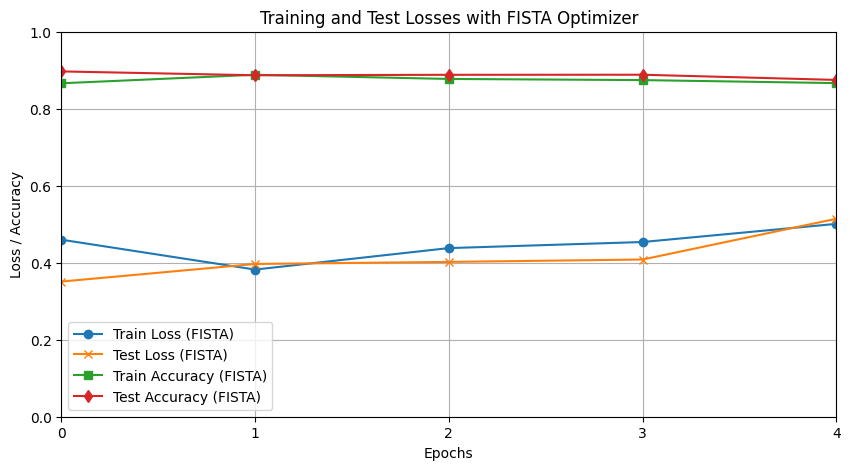

In [23]:
#load json files
with open('./metrics/train_fista_loss.json', 'r') as f:
    train_fista_loss = json.load(f)

with open('./metrics/test_fista_loss.json', 'r') as f:
    test_fista_loss = json.load(f)

with open('./metrics/train_fista_acc.json', 'r') as f:
    train_fista_acc = json.load(f)

with open('./metrics/test_fista_acc.json', 'r') as f:
    test_fista_acc = json.load(f)

# Plotting the training and test losses
plt.figure(figsize=(10, 5))
plt.plot(train_fista_loss.keys(), train_fista_loss.values(), label='Train Loss (FISTA)', marker='o')
plt.plot(test_fista_loss.keys(), test_fista_loss.values(), label='Test Loss (FISTA)', marker='x')
plt.plot(train_fista_acc.keys(), train_fista_acc.values(), label='Train Accuracy (FISTA)', marker='s')
plt.plot(test_fista_acc.keys(), test_fista_acc.values(), label='Test Accuracy (FISTA)', marker='d')

plt.xticks(list(train_fista_loss.keys()))
plt.ylim(0, 1)
plt.xlim(0, NUM_EPOCHS - 1)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss / Accuracy')
plt.title('Training and Test Losses with FISTA Optimizer')
plt.grid()
plt.show()